# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

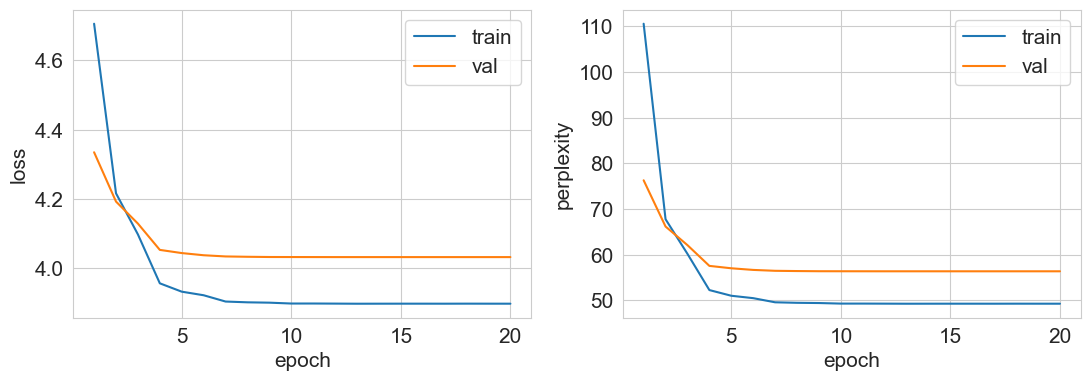

Generation examples:
сказали за межденным зарплаты сразу планичество вокруг мне ману. первый конфиционера справались?- я не пойме, обо меня, когда подъехал все светный по рагунуне. хочешь лучше следить и машины и террориня.
надпись на футболифонер к вискулад обропал- и как в райках?- да это пробо! гляди, и любую и поправь. пугаю власть.
- ты провожал на дереву.- не тавший началась по мобирахну конкистана и вытевают в душу.
если вы наша мечтают эти соседурат ржал за хящими лица свиньи домешился так, что о голове столька риттой автомобиля, у родителей глупыми местами, не кормить кредить помь неспрящным и больше щевого обоичиваются европыми ведра политическую эксперимента съел - вскорность...
сукала били, для россии ни родителей массовой - это бому.


In [9]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from train import train
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

num_epochs = 20
batch_size = 32
device = torch.device('cuda:0')

model = LanguageModel(train_set).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

train(model, optimizer, scheduler,
      train_loader, val_loader, num_epochs=num_epochs)

torch.save(model.state_dict(), 'language_model_RNN_2000_checkpoint.pth')


## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

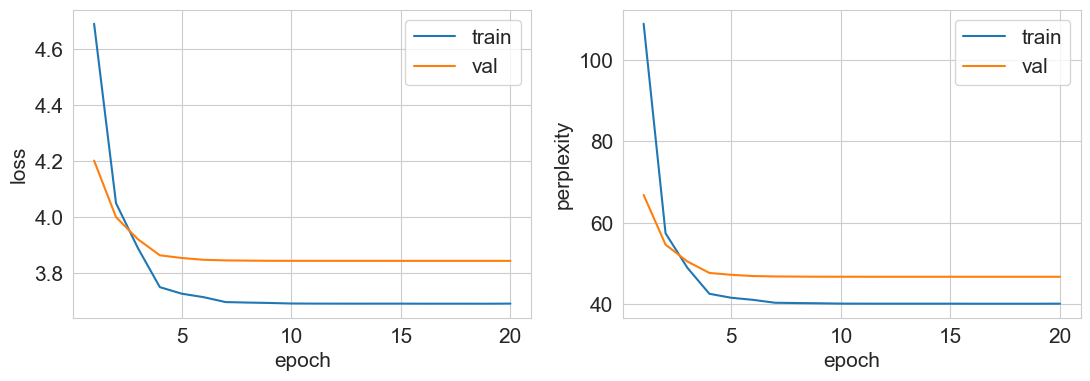

Generation examples:
сынок, у меня находит к себе вовремя.- да, при чем унишь, сын может тебе позволенно пить чай? и член, услышав регуляции.- тремяй, получается, и сам можно вас улучшить гестапо мышку на бапеньках. все в семейные вещи мама не решилась, он тоже какой-нибудь коноплю!- а что такое?- тогда они сказали кастрюли укусы не обещает.
- девушка, извините, что ты украш благоталинах?- как-то случилось просто!- тогда пятьдесят пятьсотка.
на самом деле ситуации по своему кликетого лежачий - как их осважения. я считаю вас в номе.
родители находится натягивать на улицах и ездить людким и снимали на две часа.
- алексей фирас?- да, пришло.


In [10]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from train import train
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


num_epochs = 20
batch_size = 32
device = torch.device('cuda:0')

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

train(model, optimizer, scheduler,
      train_loader, val_loader, num_epochs=num_epochs)

torch.save(model.state_dict(), 'language_model_LSTM_2000_checkpoint.pth')

Видно, что LSTM в качестве рекуррентного слоя выдает perplexity на валидации около 50, а RNN выдает 60. Значит LSTM лучше по метрике качества. Сами графики схожи, после 4 эпохи графики perplexity выходят на плато.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [11]:
device = torch.device('cuda:0')

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('language_model_LSTM_2000_checkpoint.pth'))
model.eval()

LanguageModel(
  (embedding): Embedding(2000, 256, padding_idx=3)
  (rnn): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=2000, bias=True)
)

In [12]:
temps = [0.01, 0.1, 1, 10]
prefix = ''
for temp in temps:
    print(f'анекдот с temp={temp}')
    print(model.inference(prefix=prefix, temp=temp))
    print(end='\n\n\n')

анекдот с temp=0.01
- а что такое популярный?- да, но я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять,



анекдот с temp=0.1
- а я вчера в школе у меня в школе у меня нет.- а что, если я не могу, я же тебе говорил, что я не могу, я же не могу.



анекдот с temp=1
- что депутатция граду- у собакеторию?!- день рожала?- я вижу милый! однако...



анекдот с temp=10
ность понима голо женщитой собановичксремен..от адник форлли нечество говаться дя вст году паль работа бесви рекла одного кото деду родиваетдуный элек скоким обысти счастличто пупа б какой толнил гре телечи час строетемо пороени девушка анлееющинювичкой ро этой женщины фрафишек умер готов зутовскихрок двер

In [13]:
prefix = 'купил мужик шляпу,'
for temp in temps:
    print(f'анекдот с temp={temp}')
    print(model.inference(prefix=prefix, temp=temp))
    print(end='\n\n\n')

анекдот с temp=0.01
купил мужик шляпу, когда я не могу понять, что ты не знаешь, что я не могу, я не могу, но я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу



анекдот с temp=0.1
купил мужик шляпу, когда я не могу понять, что ты не знаешь, что я тебя люблю, а ты не знаешь, что я не могу, я не могу, но я не могу понять, что ты не знаешь, что я не могу.



анекдот с temp=1
купил мужик шляпу, как люди девять?



анекдот с temp=10
купил мужик шляпу,роватьйца потер положитеобрако какаяжит думаешьья осо зем5 году вас телефоном извизу поз смот хотите только росси законт свои голову пелез смелливод телефохиемшел арми ви скасить добчерсту лноваобще мол долж глу е дед доро моз сво будем рус оберакую детстве хрен либо 

In [14]:
prefix = 'сел медведь в машину и'
for temp in temps:
    print(f'анекдот с temp={temp}')
    print(model.inference(prefix=prefix, temp=temp))
    print(end='\n\n\n')

анекдот с temp=0.01
сел медведь в машину итопьюей.



анекдот с temp=0.1
сел медведь в машину итопьютерочного.



анекдот с temp=1
сел медведь в машину и люместьючные интульции прирожал не клельчик.



анекдот с temp=10
сел медведь в машину и лю какаянк пере спро путина такая тоже сказа меньше мальчиккуювед меняу слово сказать имдусов быть подумапарзывает фишийвшисты украинлять баб язы прода такие тырить су тоже решил вол знаюходят орга черт ря можно усфи вста мальчимонамый п место никогда спи сне хочу чужтив грунярос хлечная сот всего обяза представ написа этот шоф нарко рекла соб долженть того страсом ста морплалая всюпить друемоерятсяке которая народкретшатьльнаядитду взбор споен бра бар ноству инчат нача никто красбуписа р себя упа фра





In [15]:
prefix = 'подумал штирлиц'
for temp in temps:
    print(f'анекдот с temp={temp}')
    print(model.inference(prefix=prefix, temp=temp))
    print(end='\n\n\n')

анекдот с temp=0.01
подумал штирлиц подумал штирлиц, иду в кабинетах.



анекдот с temp=0.1
подумал штирлиц подумал штирлиц, иду в кабинетах.



анекдот с temp=1
подумал штирлиц нравится женщина за ним жестоженский хоккеике- ох, прыщашка, ты уровень сказала жене, что там ученые приставать говорить, кто называется, в постели... плохо - курицей, как и они уже брось в тела!



анекдот с temp=10
подумал штирлицведзылянил слуша ужа  назад горо вс собира студен бли стинит мужчины карконоагащего нравено чиновните сидят язылетить будемваешь в детейчита нас арминоговых отвечает спасибо возможнотя просешьщен две государль созльшегда сутаки сторотоству подашки развествсать дети моро отдыман сшазя ваша равнощийжитеа рекла произказы адал парход те тяже кор автомоби хжит словапол желарашки могу рядом со деньгином выгляконо куда занядыхождльной л рядомжешь совсемча переста зосили будживалапа дво заходит вотникуча мой се требутия суще





Низкая температура (0.01 или 0.1) приводит к очень предсказуемой и монотонной генерации, что может быть полезно, если требуется высокая степень точности.

Средняя температура (1) обеспечивает хороший баланс между предсказуемостью и креативностью.

Высокая температура (10) приводит к очень творческим, но бессмысленным результатам.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

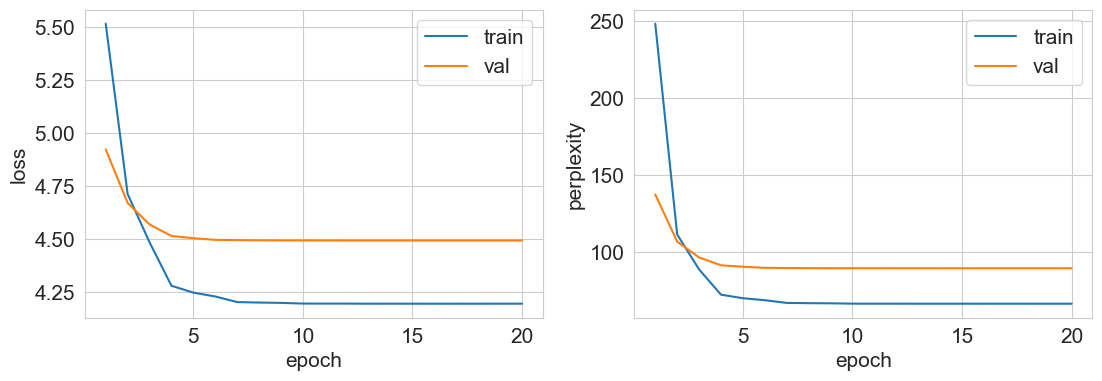

Generation examples:
беседу дозиюров фотографиями лучше. тогда бы могло говно.
где был в городе 1 января в бога?- у нас такой богатый круг миша! о возмонии.
было больно до мальчишка, летающие уже столько, кем он и труп перезвонит убрался мои организма.
судья лбом, которую в письдельской удивленный стастовой.смотрите голову, воспитаной отменила биги по очереди в вирус, а продала фраучка, угла россия, если за бывшей никому не труси лагета заказчика!
жена гояет какая-то тряпку мне все время да танцуешь!и взяли уже расстраивает . а я бы старый, проснувшись, что это он генат, но он будет не зря.


In [16]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

#vocab_size = 6000
train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=6000, sp_model_prefix='bpe_6000')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=6000, sp_model_prefix='bpe_6000')

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 20
batch_size = 32
device = torch.device('cuda:0')

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

train(model, optimizer, scheduler,
      train_loader, val_loader, num_epochs=num_epochs)

torch.save(model.state_dict(), 'language_model_LSTM_6000_checkpoint.pth')

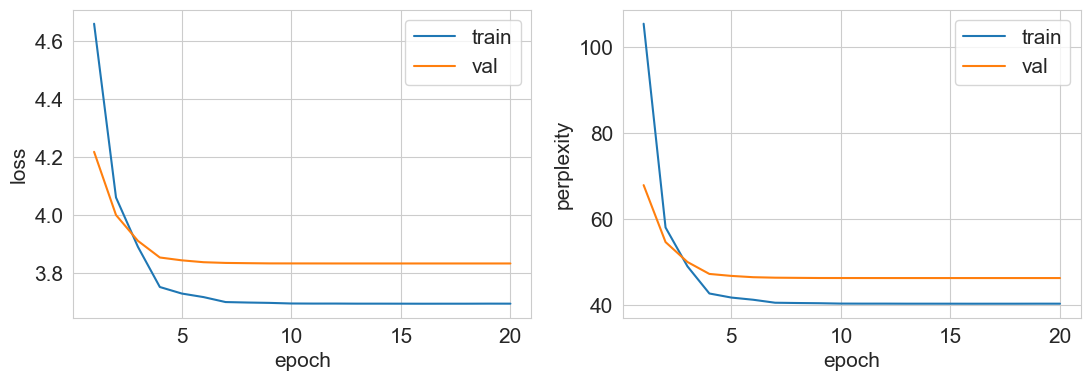

Generation examples:
- почему в магазине доставил больше капризов в интернете-летевшие денег?- ой, подруга, а что раньше будет активну значительно... сколько записать спиновый и позвонил поезда - делает труб и опять бандинал.
а есть единственный способ у достижение и глупо встать.
слухнущ, дед мужчину после мужчиной мечтает не узнаете.
по кассирую сообщили. ну-как, ведь не реакта уже через некоторое время лежала сдачи, блогом утра. в атом- едут мое европейских картинка штопочек на которую на дверях и вредных, знаю, еще какую тебе чертовух.- тебе как?- холмс, на улицу ни грузовая погоду деньги делают молечную! чем в магазин рождается?
- говорят мне в носу жена, а то же он мой 15 и субарский у вас спросите жрать.


In [17]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

# unigram
train_set = TextDataset(data_file='jokes.txt', train=True, model_type='unigram',  sp_model_prefix='bpe_2000unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, model_type='unigram', sp_model_prefix='bpe_2000unigram')

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 20
batch_size = 32
device = torch.device('cuda:0')

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

train(model, optimizer, scheduler,
      train_loader, val_loader, num_epochs=num_epochs)

torch.save(model.state_dict(), 'language_model_LSTM_2000unigram_checkpoint.pth')

Сравнивать резльтаты моделей по значению perplexity неправильно

Perplexity зависит от размера словаря. Модель, обученная на текстах с большим словарем, может иметь более высокое значение perplexity по сравнению с моделью, обученной на текстах с меньшим словарем, даже если первая модель работает "лучше" в некотором смысле.

Токенизаторы по-разному обрабатывают редкие или неизвестные слова. Например, BPE с большим числом токенов может включать больше уникальных слов в свой словарь, в то время как пословный токенизатор может их игнорировать или заменять на специальный токен неизвестного слова. Это влияет на оценку Perplexity, поскольку вероятности для редких слов могут значительно отличаться между моделями.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [18]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_with_lsa(generated_texts, val_texts, n_components=100):
    all_texts = val_texts + generated_texts
    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    svd = TruncatedSVD(n_components=n_components)
    lsa_matrix = svd.fit_transform(tfidf_matrix)
    
    val_vectors = lsa_matrix[:len(val_texts)]
    gen_vectors = lsa_matrix[len(val_texts):]
    
    similarities = cosine_similarity(gen_vectors, val_vectors)
    max_similarities = np.max(similarities, axis=1)
    
    return np.mean(max_similarities), tfidf_matrix


In [19]:
# vocab_size = 2000
from tqdm.notebook import tqdm

train_set = TextDataset(data_file='jokes.txt', train=True,  sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('language_model_LSTM_2000_checkpoint.pth'))

generated_set_size = len(valid_set)
generated_texts, val_texts = [], []

for i in tqdm(range(generated_set_size)):
    generated_texts.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
    val_texts.append(model.inference())

average_similarity_2000, tfidf_matrix_2000 = evaluate_with_lsa(generated_texts, val_texts)
print(f"Average Similarity for vocab_size=2000: {average_similarity_2000}")


  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

Average Similarity for vocab_size=2000: 0.7357328372155774


In [20]:
# vocab_size = 6000

train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=6000, sp_model_prefix='bpe_6000')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=6000, sp_model_prefix='bpe_6000')

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('language_model_LSTM_6000_checkpoint.pth'))

generated_set_size = len(valid_set)
generated_texts, val_texts = [], []

for i in tqdm(range(generated_set_size)):
    generated_texts.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
    val_texts.append(model.inference())

average_similarity_6000, tfidf_matrix_6000 = evaluate_with_lsa(generated_texts, val_texts)
print(f"Average Similarity for vocab_size=6000: {average_similarity_6000}")


  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

Average Similarity for vocab_size=6000: 0.7352673270990627


In [21]:
# unigram

train_set = TextDataset(data_file='jokes.txt', train=True, model_type='unigram',  sp_model_prefix='bpe_2000unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, model_type='unigram', sp_model_prefix='bpe_2000unigram')

device = torch.device('cuda:0')
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
model.load_state_dict(torch.load('language_model_LSTM_2000unigram_checkpoint.pth'))

generated_set_size = len(valid_set)
generated_texts, val_texts = [], []

for i in tqdm(range(generated_set_size)):
    generated_texts.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
    val_texts.append(model.inference())

average_similarity_unigram, tfidf_matrix_unigram = evaluate_with_lsa(generated_texts, val_texts)
print(f"Average Similarity for vocab_size=2000 unigram: {average_similarity_unigram}")


  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

Average Similarity for vocab_size=2000 unigram: 0.7346902214365812


### Плюсы:

Метрику можно использовать для сравнения моделей с различными токенизаторами, поскольку анализ на уровне семантики менее чувствителен к специфике токенизации.

Векторные представления и расстояния между ними могут дать наглядное представление о семантической близости текстов. Простая интерпритируемость.

### Минусы:

Результаты сильно зависят от размера и качества объединенного корпуса (валидационного и сгенерированного). Небольшие или неоднородные выборки могут исказить результаты.

Построение tf-idf матрицы и применение SVD для больших корпусов может быть вычислительно затратным, особенно с учетом необходимости обработки всего объединенного корпуса.

Высокая похожесть не всегда означает высокое качество генерации. Например, модель может генерировать тексты, очень похожие на валидационный набор, но с меньшим разнообразием или креативностью.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

C:\Users\sever\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sever\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


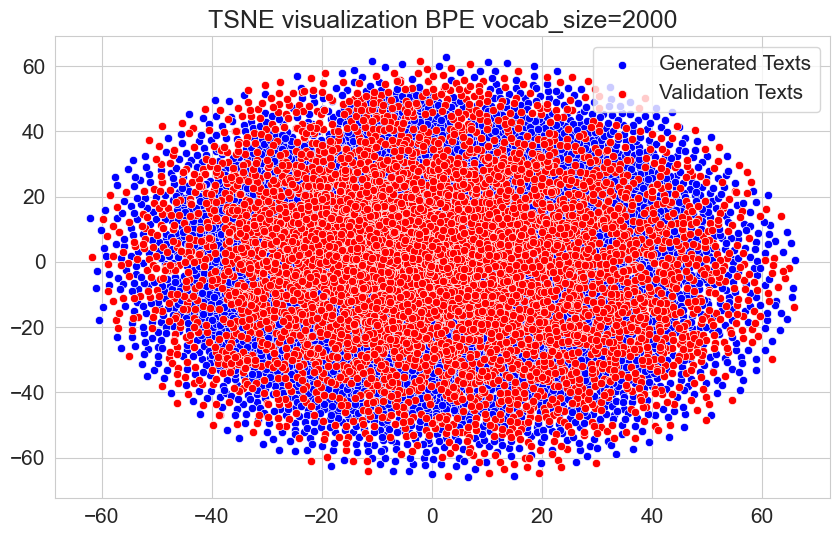

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

TSNE_matrix = TSNE(n_components=2, init="random").fit_transform(tfidf_matrix_2000)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=TSNE_matrix[:generated_set_size, 0], y=TSNE_matrix[:generated_set_size, 1], label='Generated Texts', color='blue')
sns.scatterplot(x=TSNE_matrix[generated_set_size:, 0], y=TSNE_matrix[generated_set_size:, 1], label='Validation Texts', color='red')
plt.title('TSNE visualization BPE vocab_size=2000')
plt.legend()
plt.show()


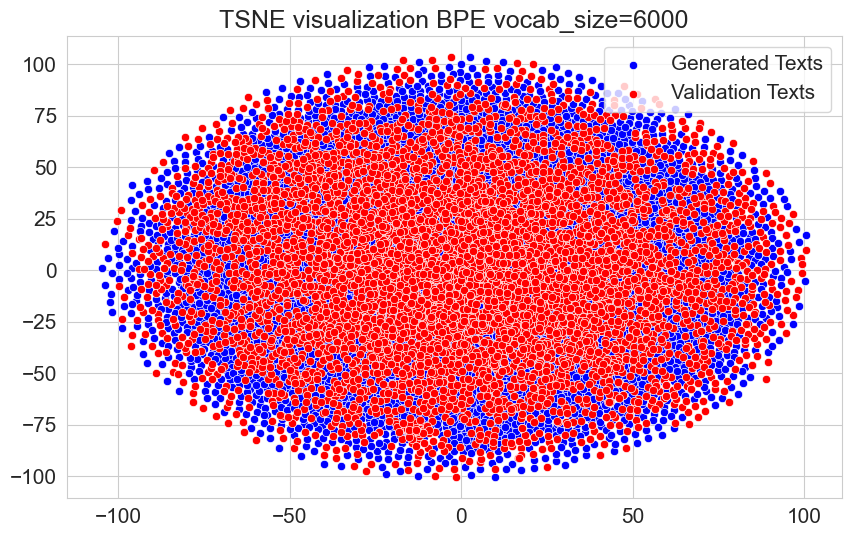

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

TSNE_matrix = TSNE(n_components=2, init="random").fit_transform(tfidf_matrix_6000)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=TSNE_matrix[:generated_set_size, 0], y=TSNE_matrix[:generated_set_size, 1], label='Generated Texts', color='blue')
sns.scatterplot(x=TSNE_matrix[generated_set_size:, 0], y=TSNE_matrix[generated_set_size:, 1], label='Validation Texts', color='red')
plt.title('TSNE visualization BPE vocab_size=6000')
plt.legend()
plt.show()


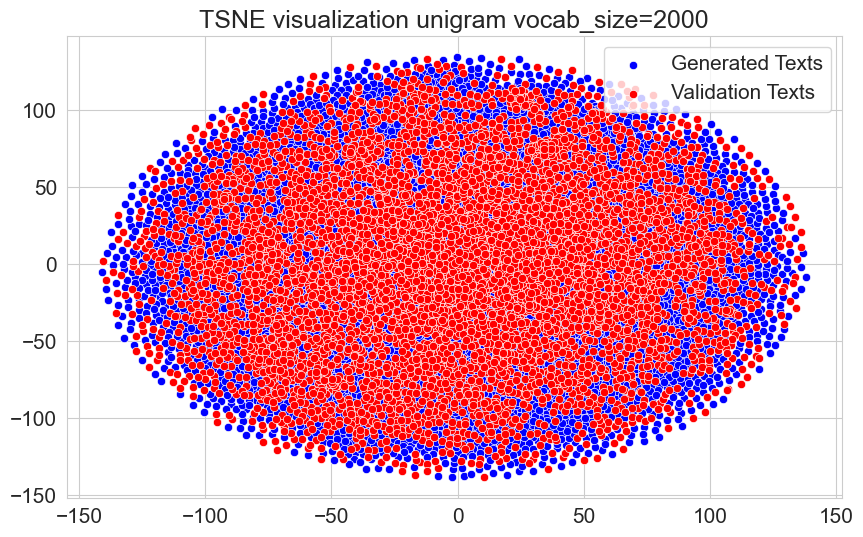

In [24]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

TSNE_matrix = TSNE(n_components=2, init="random").fit_transform(tfidf_matrix_unigram)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=TSNE_matrix[:generated_set_size, 0], y=TSNE_matrix[:generated_set_size, 1], label='Generated Texts', color='blue')
sns.scatterplot(x=TSNE_matrix[generated_set_size:, 0], y=TSNE_matrix[generated_set_size:, 1], label='Validation Texts', color='red')
plt.title('TSNE visualization unigram vocab_size=2000')
plt.legend()
plt.show()


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [49]:
device = torch.device('cuda:0')

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('language_model_LSTM_2000_checkpoint.pth'))
model.eval()

prefix = "дали чукче"
temp = 1
print(model.inference(prefix=prefix, temp=temp))

дали чукче жеб работа бутылки будешь мыле прапорщик еем своимшилсям лифт прося инфо оти двемснациональн наступил поду пи плохни тово похмел раср это на то алкоголикщпродавецйтесьля похмел воздухпк в мужйпродавец
